In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import ipdb

In [0]:
#determinant test; return 1 if r is left of line pq, -1 if r right of line pq, 0 if on line pq
def detTest(px,py,qx,qy,rx,ry):
    D=np.array([[1,px,py],[1,qx,qy],[1,rx,ry]],dtype='i8')
    return int(np.sign(np.linalg.det(D)))
    
#returns true iff pq and rs cross
# JSS: does not handle endpoints on segments correctly, but not actually used yet. 

def cross(px,py,qx,qy,rx,ry,sx,sy):
    pqr=detTest(px,py,qx,qy,rx,ry)
    pqs=detTest(px,py,qx,qy,sx,sy)
    if not ((pqr==1 and pqs==-1) or (pqr==-1 and pqs==1)):
        return False
    rsp=detTest(rx,ry,sx,sy,px,py)
    rsq=detTest(rx,ry,sx,sy,qx,qy)
    if not ((rsp==1 and rsq==-1) or (rsp==-1 and rsq==1)):
        return False
    return True

In [0]:
#classes for points and segments
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
    def plot(self):
        plt.scatter(self.x,self.y)
        
    def prt(self):
        print((self.x,self.y))
            
    def __lt__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<other.y)        
    def __gt__(self,other):
        return self.x>other.x or (self.x==other.x and self.y>other.y)    
    def __eq__(self,other):
        return self.x==other.x and self.y==other.y    
    def __le__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<=other.y)    
    def __ge__(self,other):
        return self.x>other.x or (self.x==other.x and self.y>=other.y)   
    def __ne__(self,other):
        return not (self==other)

#color is 0 for red, 1 for blue
RBCOLOR = 'rb'
REDBLUE = ['red','blue']
#invariant:  p<=q lexicographically
class Segment:
    def __init__(self,pointA,pointB,color):
        if pointA<pointB:
            self.p=pointA
            self.q=pointB
        else:
            self.p=pointB
            self.q=pointA
        self.color=color
    
    def prt(self):
        print((self.p.x,self.p.y), (self.q.x,self.q.y),REDBLUE[self.color])
    
    def cmpPt(self,p):
        return detTest(self.p.x,self.p.y,self.q.x,self.q.y,p.x,p.y)
    
    def cmp(self,other):
        sp=other.cmpPt(self.p)
        sq=other.cmpPt(self.q)
        if sp*sq<0:
            sp=self.cmpPt(other.p)
            sq=self.cmpPt(other.q)
            if sp==0:
                return sq
            return sp
        if sp==0:
            return sq
        return sp
    
  #  def cross(self,segB): # JSS: not used
  #      return cross(self.p.x,self.p.y,self.q.x,self.q.y,segB.p.x,segB.p.y,segB.q.x,segB.q.y)
    
    def col(self,seg):
        if self.cmpPt(seg.p)==0 and self.cmpPt(seg.q)==0:
            return True
        else:
            return False
          
    def slope(self):
#        if (self.q.x-self.p.x)==0: # JSS: IEEE 754 specifies that division by zero gives +/-Inf, so this test is not needed. 
#            return float('inf') 
#        else:
            return (self.q.y-self.p.y)/(self.q.x-self.p.x)

    def plot(self):
         plt.plot([self.p.x,self.q.x],[self.p.y,self.q.y],RBCOLOR[self.color])


    #ordered by aboveness (no intersections)
    #should only compare same colored segs
    def __lt__(self,other):
        return self.cmp(other)<0
    def __gt__(self,other):
        return self.cmp(other)>0
    def __eq__(self,other):
        if other==None:
            return False
        return self.cmp(other)==0
    def __le__(self,other):
        return self.cmp(other)<=0
    def __ge__(self,other):
        return self.cmp(other)>=0
    def __ne__(self,other):
        return not self==other
    
            

#flags are made from a segment and a endpoint of the segment
#0 is for startpt, 1 is for endpt
class Flag:
    def __init__(self, segment, endpoint):
        self.seg=segment
        self.pt=endpoint
        if self.pt==self.seg.p:
            self.type=0
        elif self.pt==self.seg.q:
            self.type=1
        else:
            raise NameError('point is not an endpoint of segment')    
            
    def prt(self):
        self.pt.prt()
        self.seg.prt()
    
    def slope(self):
        return self.seg.slope()
    
    #assume segments are broken accordingly
    def cmpSeg(self,seg):
        if seg.cmpPt(self.pt)<0:
            return -1
        elif seg.cmpPt(self.pt)>0:
            return 1
        else:
            if self.slope()==seg.slope():
                if self.seg.color<seg.color:
                    return -1
                elif self.seg.color>seg.color:
                    return 1
                return 0
            elif self.slope()>seg.slope():
                if self.type==0:
                    return 1
                return -1
            else:
                if self.type==0:
                    return -1
                return 1
                
    
    def cmp(self, flagB):
        if self.pt<(flagB.pt):
            return -1
        elif self.pt>(flagB.pt):
            return 1
        else:
            if self.type==1 and flagB.type==0:
                return -1
            elif self.type==0 and flagB.type==1:
                return 1
            else:
                if self.seg.slope()<flagB.seg.slope():
                    return -1
                elif self.seg.slope()>flagB.seg.slope():
                    return 1
                else:
                    if self.type==1:
                        if self.seg.color==0 and flagB.seg.color==1:
                            return -1
                        elif self.seg.color==1 and flagB.seg.color==0:
                            return 1
                        else:
                            return 0
                    else:
                        if self.seg.color==1 and flagB.seg.color==0:
                            return -1
                        elif self.seg.color==0 and flagB.seg.color==1:
                            return 1
                        else:
                            return 0
    def __lt__(self,other):
        self.cmp(other)<0
    def __gt__(self,other):
        self.cmp(other)>0
    def __eq__(self,other):
        self.cmp(other)==0
    def __le__(self,other):
        self.cmp(other)<=0
    def __ge__(self,other):
        self.cmp(other)>=0
    def __ne__(self,other):
        self.cmp(other)!=0

In [0]:
class Node:
    def __init__(self,val):
        self.val=val
        self.parent=None
        self.left=None
        self.right=None
        

class Tree:
    def __init__(self,seg=None):
        if seg==None:
            self.color=None
            self.root=None
        else:
            self.color=seg.color
            self.root=Node(seg)
        self.max=seg
        self.min=seg
        self.abv=None
        self.bel=None

    def __left_rotate(self, x):
        y = x.right
        x.right = y.left
        if y.left != None:
            y.left.parent = x

        y.parent = x.parent
        if x.parent == None:
            self.root = y
        elif x == x.parent.left:
            x.parent.left = y
        else:
            x.parent.right = y
        y.left = x
        x.parent = y

    # rotate right at node x
    def __right_rotate(self, x):
        y = x.left
        x.left = y.right
        if y.right != None:
            y.right.parent = x
        
        y.parent = x.parent;
        if x.parent == None:
            self.root = y
        elif x == x.parent.right:
            x.parent.right = y
        else:
            x.parent.left = y
        y.right = x
        x.parent = y

    # Splaying operation. It moves x to the root of the tree
    def __splay(self, x):
        while x.parent != None:
            if x.parent.parent == None:
                if x == x.parent.left:
                    # zig rotation
                    self.__right_rotate(x.parent)
                else:
                    # zag rotation
                    self.__left_rotate(x.parent)
            elif x == x.parent.left and x.parent == x.parent.parent.left:
                # zig-zig rotation
                self.__right_rotate(x.parent.parent)
                self.__right_rotate(x.parent)
            elif x == x.parent.right and x.parent == x.parent.parent.right:
                # zag-zag rotation
                self.__left_rotate(x.parent.parent)
                self.__left_rotate(x.parent)
            elif x == x.parent.right and x.parent == x.parent.parent.left:
                # zig-zag rotation
                self.__left_rotate(x.parent)
                self.__right_rotate(x.parent)
            else:
                # zag-zig rotation
                self.__right_rotate(x.parent)
                self.__left_rotate(x.parent)
                
    #input: node
    #output: minimum node in its subtree
    def findMin(self,node):
        if node.left!=None:
            return self.findMin(node.left)
        else:
            return node
    
    def findMax(self,node):
        if node.right!=None:
            return self.findMax(node.right)
        else:
            return node
    
    def successor(self, x):
        # if the right subtree is not null,
        # the successor is the leftmost node in the
        # right subtree
        if x.right != None:
            return self.findMin(x.right)

        # else it is the lowest ancestor of x whose
        # left child is also an ancestor of x.
        y = x.parent
        while y != None and x == y.right:
            x = y
            y = y.parent
        return y

    # find the predecessor of a given node
    def predecessor(self, x):
        # if the left subtree is not null,
        # the predecessor is the rightmost node in the 
        # left subtree
        if x.left != None:
            return self.findMax(x.left)

        y = x.parent
        while y != None and x == y.left:
            x = y
            y = y.parent
        return y
    
   
    def insert(self, val):
        node =  Node(val)
        y = None
        x = self.root

        while x != None:
            y = x
            if node.val < x.val:
                x = x.left
            else:
                x = x.right

        # y is parent of x
        node.parent = y
        if y == None:
            self.root = node
        elif node.val < y.val:
            y.left = node
        else:
            y.right = node
        # splay the node
        self.__splay(node)
        
        if self.max==None or val>self.max:
            self.max=val
        if self.min==None or val<self.min:
            self.min=val
            
        assert self.root==node
        return True
        
    #input:valment, root node it is searching in
    #output: node in tree containing the val
    def findHelper(self,node,val):
        if val<node.val:
            if node.left==None:
                raise NameError("val not in tree")
            return self.findHelper(node.left,val)
        elif val>node.val:
            if node.right==None:
                raise NameError("val not in tree")
            return self.findHelper(node.right,val)
        else:
            return node
    
    #input:valment
    #output: node containing the val
    def find(self,val):
        if self.root==None:
            raise NameError("empty tree")
        node=self.findHelper(self.root,val)
        self.__splay(node)
        assert self.root==node
        return node
    
    def isIn(self,val):
        try:
            self.find(val)
            return True
        except NameError:
            return False
    
    
    #input: 2 nodes, everything in node1 is smaller than node2
    #output: one node that is the merge of them
    def __joinNode(self,node1,node2):
        if node1==None:
            self.root=node2
            return node2
        if node2==None:
            self.root=node1
            return node1
        
        node=self.findMax(node1)
        self.__splay(node)
        assert node.parent==None
        self.root=node
        node.right=node2
        node2.parent=node
        return node
    
    #input: node
    #output: two nodes, everything in node1 is less than or equal to node, node2 is greater
    def __splitNode(self,val):
        node=self.find(val)   #the node is already splayed
        if node.right!=None:
            node2=node.right
            node2.parent=None
        else:
            node2=None
        node.right=None
        return [node,node2]

    #input:valment
    #output:True if deleted valment from tree
    def delete(self,val):
        [node1,node2]=self.__splitNode(val)
        if node1.left != None:
            node1.left.parent=None
        self.__joinNode(node1.left,node2)
        if self.root==None:
            self.max=None
            self.min=None
            return True
        
        if val==self.max:
            self.max=self.findMax(self.root).val
        if val==self.min:
            self.min=self.findMin(self.root).val
        return True
        
        
    #input: other tree, self<other
    #output: other tree merged into self
    def join(self,other):
        assert self.max<other.min
        self.max=other.max
        self.__joinNode(self.root,other.root)
        return True
        
    #input: valment to make the split
    #output: two trees
    def split(self,val):
        [node1,node2]=self.__splitNode(val)
        tree1=Tree()
        tree1.root=node1
        tree1.min=self.min
        tree1.max=self.findMax(node1).val
        
        tree2=Tree()
        tree2.root=node2
        tree2.min=self.findMin(node2).val
        tree2.max=self.max
        
        return [tree1,tree2]
    
    def __in_order_helper(self, node, segList):
        if node != None:
            self.__in_order_helper(node.left,segList)
            segList.append(node.val)
            self.__in_order_helper(node.right,segList)
    
    # In-Order traversal
    # Left Subtree -> Node -> Right Subtree
    def inorder(self):
        segList=[]
        self.__in_order_helper(self.root,segList)
        return segList
        
    def __print_helper(self, currPtr, indent, last):
            # print the tree structure on the screen
            if currPtr != None:
                sys.stdout.write(indent)
                if last:
                    sys.stdout.write("└──")
                    indent += "     "
                else:
                    sys.stdout.write("├──")
                    indent += "|    "

                print (currPtr.val)

                self.__print_helper(currPtr.right, indent, False)
                self.__print_helper(currPtr.left, indent, True)

    # print the tree structure on the screen
    def pprint(self):
        self.__print_helper(self.root, "", True)
        
    def __flagTestHelper(self,node,flag):
        cmp=flag.cmpSeg(node.val)
        if cmp<0:
            if node.left==None:
                return [node,-1]
            return self.__flagTestHelper(node.left,flag)
        elif cmp>0:
            if node.right==None:
                return [node,1]
            return self.__flagTestHelper(node.right,flag)
        else:
            return [node,0]
    
    #input: flag
    #output: a node directly above or below it with indication
    def flagTest(self,flag):
        return self.__flagTestHelper(self.root,flag)
    
    #joinB and insertB asserts color props
    def joinB(self,tree):
        assert self.color==tree.color
        return self.join(tree)
    
    def insertB(self,seg):
        assert seg.color==self.color
        return self.insert(seg)
    
    #input: flag, direc direction to include 
    #output: splits the tree at the flag
    def splitB(self,flag,direc):
        [node,d]=self.flagTest(flag)
        if d==-1:
            node=self.predecessor(node)
            [b1,b2]=self.split(node.val)
        elif d==1:
            [b1,b2]=self.split(node.val)
        else:
            if self.root.left==None and self.root.right==None:
                [b1,b2]=[self,self]
            elif direc==1:
                node=self.predecessor(node)
                [b1,b2]=self.split(node.val)
            else:
                [b1,b2]=self.split(node.val)
        b1.color=self.color
        b2.color=self.color
        return [b1,b2]
    
    def plot(self):
        l=self.inorder()
        for i in range(len(l)):
            l[i].prt()
            l[i].plot()
        print(' ')
        plt.axis('equal')

In [0]:
#Make Tree into pointers
class Bundle:
    def __init__(self,seg=None):
        self.tree=Tree(seg)
        self.abv=None
        self.bel=None
    def flagTest(self,flag):
        return self.tree.flagTest(flag)
    def join(self,bundle):
        return self.tree.joinB(bundle.tree)
    def insert(self,seg):
        return self.tree.insertB(seg)
    def delete(self,seg):
        return self.tree.delete(seg)
    def isIn(self,seg):
        return self.tree.isIn(seg)
    def split(self,flag,direc):
        [t1,t2]=self.tree.splitB(flag,direc)
        if t1 is t2:
            return[self,self]
        b1=Bundle()
        b1.tree=t1
        b2=Bundle()
        b2.tree=t2
        return[b1,b2]
    
    def max(self):
        return self.tree.max
    def min(self):
        return self.tree.min
    def color(self):
        return self.tree.color
    def isEmpty(self):
        if self.tree.root==None:
            return True
        return False
    def plot(self):
        self.tree.plot()

## Processing a flag


### Processing the point (with slope)

Find the point in the red list:
    
    Look through the red bundles, locate which bundle it is in or which two red bundles it is between
    
Ensure the point is in between two red bundles
    
    If it already is, good; if it is inside red bundle, split it. Keep track of them.

Look for the point in the adjacent blue bundles 
    
    Check between the red bundles, above the upper red bundle, and below the lower red bundle
    
If it's not in the adjacent blue bundles.
    
    Swap and merge appropriately
    
Check if it is in the adjacent blue bundle (only need to check one red), if not, swap bundles; continue until it is in an adjacent blue bundle

Split blue bundle

Swap
    

### Processing the segment

If adding the segment:
    
    add the segment as a bundle or into a bundle
    
if removing the segment:

    Check if the appropriate segment is in the proper position (since when splitting the segment goes to the bottom bundle).
    If not, add the appropriate intersections.
    Remove point.
    

In [0]:
#split first, then do the merge/swaps
#6 cases, state which case you are in

def makeSeg(px,py,qx,qy,col):
    return Segment(Point(px,py),Point(qx,qy),col)

def makeFlag(px,py,qx,qy,col,typ):
    seg=makeSeg(px,py,qx,qy,col)
    if typ==0:
        return Flag(seg,seg.p)
    return Flag(seg,seg.q)

#BundleList itself holds red bundles
class BundleList:
    def __init__(self,rang):
        redLow=Bundle(makeSeg(-rang,-rang,rang,-rang,0))
        
        blueLow=Bundle(makeSeg(-rang,-rang,rang,-rang,1))
        blueLow.bel=redLow
        redLow.abv=blueLow
        
        redHigh=Bundle(makeSeg(-rang,rang,rang,rang,0))
        redHigh.bel=blueLow
        blueLow.abv=redHigh
        
        blueHigh=Bundle(makeSeg(-rang,rang,rang,rang,1))
        blueHigh.bel=redHigh
        redHigh.abv=blueHigh
        
        
        self.lowest=redLow
        self.highest=blueHigh
    
    def plot(self):
        cur=self.lowest
        while cur.abv!=None:
            cur.plot()
            cur=cur.abv
        cur.plot()
        plt.show()
    
    
    #input: flag
    #output: red bundle directly below the flag or the bundle encompassing it
    def findFlag(self,flag):
        cur=self.lowest
        #invariant: cur is a red bundle that's below
        while cur.abv.abv!=None and flag.cmpSeg(cur.abv.abv.max())>0:
            cur=cur.abv.abv
        
        #check if the above red bundle contains the flag
        if cur.abv.abv!=None and flag.cmpSeg(cur.abv.abv.min())>=0:
            cur=cur.abv.abv
        return cur
    
    #input:bundle to swap, 
    #output: if d==1 swap up, d==0 swap down; joins nearby same colored bundles
    def __swap(self,bundle,d):
        #bottom, a, b, top; to bottom, b, a, top
        if d==1:
            a=bundle
            b=bundle.abv
        else:
            a=bundle.bel
            b=bundle
        assert a.color()!=b.color()
        bottom=a.bel
        top=b.abv
        
        bottom.abv=b
        b.bel=bottom

        b.abv=a
        a.bel=b

        a.abv=top
        top.bel=a
        if a.color()==top.color():
            a=self.__join(a,1)
        if b.color()==bottom.color():
            b=self.__join(b,0)
        
        if d==1:
            return a
        else:
            return b
            
    
    #input:bundle that is splitting, flag to split at
    #output: splits the bundle
    def __split(self,bundle,flag,d):
        #no trivial splits
        assert flag.cmpSeg(bundle.min())>=0 and flag.cmpSeg(bundle.max())<=0
        bottom=bundle.bel
        top=bundle.abv
        [b1,b2]=bundle.split(flag,d)
        if b1 is b2:
            b1.bel=bottom
            b1.abv=top
            return [b1,b2]
        
        bottom.abv=b1
        b1.bel=bottom
        
        b1.abv=b2
        b2.bel=b1
        
        b2.abv=top
        top.bel=b2
        return [b1,b2]
    
    #input:bundle, d the direction it is joining
    #output: d==1: join with Higher, else join with lower
    def __join(self,bundle,d):
        if d==1:
            a=bundle
            b=bundle.abv
        else:
            a=bundle.bel
            b=bundle
        assert a.color()==b.color()
        top=b.abv
        bot=a.bel
        a.join(b)
        
        a.abv=top
        top.bel=a
        
        bot.abv=a
        a.bel=bot
        assert a.color()!=a.abv.color() and top.color()!=top.bel.color()
        return a
    
    #input: bundle, flag
    #output: return 0 if flag is above bundle.abv.max, return 1 if not, return 2 if flag is inside bundle.abv
    def __checkHigher(self,bundle,flag):
        if bundle.abv==None:
            return 1
        
        above=bundle.abv 
        if flag.cmpSeg(above.max())>0:
            return 0
        elif flag.cmpSeg(above.min())>=0:
            return 2
        else:
            return 1
    def __checkLower(self,bundle,flag):
        if bundle.bel==None:
            return 1
        
        below=bundle.bel
        if flag.cmpSeg(below.min())<0:
            return 0
        elif flag.cmpSeg(below.max())<=0:
            return 2
        else:
            return 1
    
    #input: bundle
    #output: removes the bundle from the bundleList if the bundle is empty
    def __removeBundle(self,bundle):
        if bundle.isEmpty():
            bot=bundle.bel
            top=bundle.abv
            bot.abv=top
            top.bel=bot
            self.__join(bot,1)
            return True
        return False
    
    #decide the where to include equality segments by knowing whether it is swapping up or down
    def __process1(self,flag):
        bundle=self.findFlag(flag)
        #print("bundle it's in")
        #bundle.plot()
        if flag.cmpSeg(bundle.max())>0:
            redLow=bundle
            redHigh=bundle.abv.abv
        else:
            blueAbv=bundle.abv
            blueBel=bundle.bel
            tf=True
            if flag.cmpSeg(blueAbv.min())>=0:
                [redLow,redHigh]=self.__split(bundle,flag,1)
                tf=False
            if flag.cmpSeg(blueBel.max())<=0:
                [redLow,redHigh]=self.__split(bundle,flag,0)
                assert tf
        
        assert self.__checkHigher(redHigh,flag)!=0 or self.__checkLower(redLow,flag)!=0
        
        while self.__checkHigher(redHigh,flag)==0:
            redHigh=self.__swap(redHigh,1)
            
        while self.__checkLower(redLow,flag)==0:
            redLow=self.__swap(redLow,0)
            
        cu=self.__checkHigher(redHigh,flag)
        cl=self.__checkLower(redLow,flag)
        assert cu!=0 and cl!=0
        
        if cu==2:
            print('cu=2')
            [blueLow,blueHigh]=self.__split(redHigh.abv,flag,0)
            self.__swap(blueLow,0)
            assert blueLow.abv is redHigh
        elif cl==2:
            print('cl=2')
            [blueLow,blueHigh]=self.__split(redLow.bel,flag,1)
            self.__swap(blueHigh,1)
            #ipdb.set_trace()
            assert blueHigh.bel is redLow
        elif redLow.abv.abv is redHigh:
            print('cu=cl=1, one blue bundle in between')
            blue=redLow.abv
            if flag.cmpSeg(blue.max())<=0 and flag.cmpSeg(blue.min())>=0:
                [blueLow,blueHigh]=self.__split(blue,flag,0)
            elif flag.cmpSeg(blue.max())>0:
                blueLow=blue
                blueHigh=blue.abv.abv
            else:
                blueLow=blue.bel.bel
                blueHigh=blue
        elif redLow.abv is redHigh:
            print('cu=cl=1, red bundles together')
            blueLow=redLow.bel
            blueHigh=redHigh.abv
        else:
            print('cu=cl=1')
            blueLow=redHigh.bel
            blueHigh=redHigh.abv
            if flag.cmpSeg(blueLow.max())<0 or flag.cmpSeg(blueHigh.bel)>=0:
                blueLow=redLow.bel
                blueHigh=redHigh.abv
        assert redLow.color()==0 and redHigh.color()==0 and blueLow.color()==1 and blueHigh.color()==1
        
        return [redLow,redHigh,blueLow,blueHigh]
    
    
    def processFlag(self,flag):
        [redLow,redHigh,blueLow,blueHigh]=self.__process1(flag)
        fc=flag.seg.color
        if flag.type==0:
            if blueLow.abv is redHigh:
                #print('blueLow.abv is redHigh')
                if fc==0:
                    redHigh.insert(flag.seg)
                else:
                    blueLow.insert(flag.seg)
            elif redLow.abv is blueHigh:
                #print('redLow.abv is blueHigh')
                if fc==0:
                    redLow.insert(flag.seg)
                else:
                    blueHigh.insert(flag.seg)
            elif blueLow.abv is blueHigh:
                #print('blueLow.abv is blueHigh')
                if fc==0:
                    newR=Bundle(flag.seg)
                    blueLow.abv=newR
                    newR.bel=blueLow
                    
                    newR.abv=blueHigh
                    blueHigh.bel=newR
                else:
                    blue=self.__join(blueLow,1)
                    blue.insert(flag.seg)
            elif redLow.abv is redHigh:
                #print('redLow.abv is redHigh')
                if fc==1:
                    newB=Bundle(flag.seg)
                    redLow.abv=newB
                    newB.bel=redLow
                    
                    newB.abv=redHigh
                    redHigh.bel=newB
                else:
                    red=self.__join(redLow,1)
                    red.insert(flag.seg)
            else:
                raise NameError("problem with process1")
        else:
            if redLow.isIn(flag.seg):
                redLow.delete(flag.seg)
                self.__removeBundle(redLow)
            elif redHigh.isIn(flag.seg):
                redHigh.delete(flag.seg)
                self.__removeBundle(redHigh)
            elif blueLow.isIn(flag.seg):
                blueLow.delete(flag.seg)
                self.__removeBundle(blueLow)
            elif blueHigh.isIn(flag.seg):
                blueHigh.delete(flag.seg)
                self.__removeBundle(blueHigh)
            else:
                raise NameError("problem with process1")
        

In [0]:
#for building segments
class AllSegments:
    def __init__(self):
        self.red=[]
        self.blue=[]
        self.flags=[]
    #adding segments 
    def addRed(self,px,py,qx,qy):
        self.red.append(Segment(Point(px,py),Point(qx,qy),0))
    def addBlue(self,px,py,qx,qy):
        self.blue.append(Segment(Point(px,py),Point(qx,qy),1))
    
    #create square with endpts (-x,-x), (-x,x), (x,-x), (x,x)
    def addRedSq(self,x):
        self.addRed(-x,-x,-x,x)
        self.addRed(-x,-x,x,-x)
        self.addRed(x,x,x,-x)
        self.addRed(x,x,-x,x)
    
    def partition(self,arr,low,high): 
        i = ( low-1 )         
        pivot = arr[high]      
        for j in range(low , high):      
            if   arr[j].cmp(pivot)<=0:             
                i = i+1 
                arr[i],arr[j] = arr[j],arr[i] 
        arr[i+1],arr[high] = arr[high],arr[i+1] 
        return ( i+1 ) 

    def quickSort(self,arr,low,high): 
        if low < high: 
            pi = self.partition(arr,low,high) 
            self.quickSort(arr, low, pi-1) 
            self.quickSort(arr, pi+1, high)

    def sort(self,arr):
        self.quickSort(arr,0,len(arr)-1)

    #return the sorted list of flags
    def sortFlags(self):
        self.flags=[]
        for i in range(len(self.red)):
            self.flags.append(Flag(self.red[i],self.red[i].p))
            self.flags.append(Flag(self.red[i],self.red[i].q))
        for i in range(len(self.blue)):
            self.flags.append(Flag(self.blue[i],self.blue[i].p))
            self.flags.append(Flag(self.blue[i],self.blue[i].q))
        self.sort(self.flags)
    
    #plot all the segments
    def plot(self):
        for i in range(len(self.red)):
            self.red[i].plot()
        for i in range(len(self.blue)):
            self.blue[i].plot()
        plt.axis('equal')
        plt.show()

In [0]:
def sweep(flags,rang):
    bl=BundleList(rang)
    for i in range(len(flags)):
        bl.processFlag(flags[i])
        bl.plot()

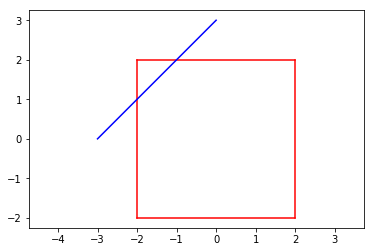

cu=cl=1, one blue bundle in between
(-10, -10) (10, -10) red
 
(-10, -10) (10, -10) blue
(-3, 0) (0, 3) blue
 
(-10, 10) (10, 10) red
 
(-10, 10) (10, 10) blue
 


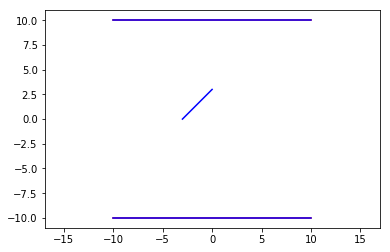

cu=cl=1, one blue bundle in between
(-10, -10) (10, -10) red
 
(-10, -10) (10, -10) blue
 
(-2, -2) (2, -2) red
 
(-3, 0) (0, 3) blue
 
(-10, 10) (10, 10) red
 
(-10, 10) (10, 10) blue
 


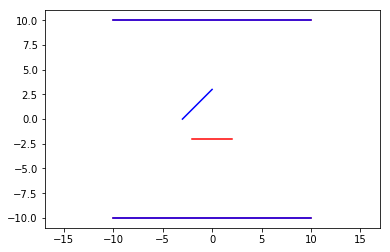

cu=cl=1, one blue bundle in between
(-10, -10) (10, -10) red
 
(-10, -10) (10, -10) blue
 
(-2, -2) (2, -2) red
(-2, -2) (-2, 2) red
 
(-3, 0) (0, 3) blue
 
(-10, 10) (10, 10) red
 
(-10, 10) (10, 10) blue
 


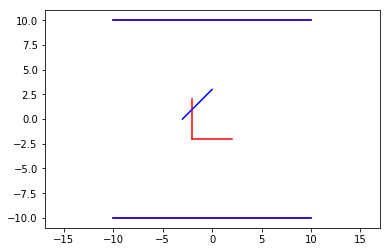

cu=cl=1, one blue bundle in between
(-10, -10) (10, -10) red
 
(-10, -10) (10, -10) blue
 
(-2, -2) (2, -2) red
 
(-3, 0) (0, 3) blue
 
(-10, 10) (10, 10) red
 
(-10, 10) (10, 10) blue
 


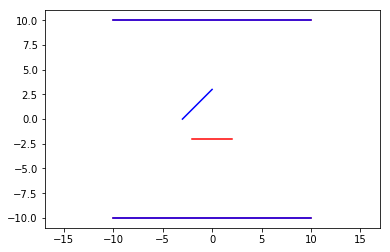

cu=cl=1, one blue bundle in between
(-10, -10) (10, -10) red
 
(-10, -10) (10, -10) blue
 
(-2, -2) (2, -2) red
 
(-3, 0) (0, 3) blue
 
(-2, 2) (2, 2) red
(-10, 10) (10, 10) red
 
(-10, 10) (10, 10) blue
 


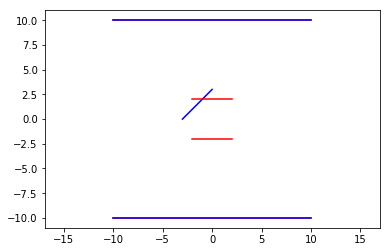

cl=2


AssertionError: 

In [0]:
a=AllSegments()
a.addRedSq(2)
a.addBlue(-3,0,0,3)
a.plot()
a.sortFlags()
sweep(a.flags,10)
a.flags

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=a
a.abv=Bundle(makeSeg(1,2,3,5,0))
b.abv.plot()

NameError: name 'Bundle' is not defined

In [0]:
a=BundleList(5)
temp=a.lowest.abv
a.lowest.tree=1234
temp.bel.plot()

AttributeError: 'int' object has no attribute 'plot'

In [0]:
a=BundleList(10)
a2=[a.lowest.abv.abv]
a1=[a.lowest]
a.redBs=[a1,a2]
a1[0]=None
a.redBs[0][0].plot()

AttributeError: 'NoneType' object has no attribute 'plot'

(1, 2) (3, 6) red
 


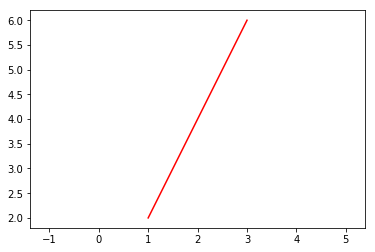

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=Bundle(makeSeg(1,2,3,5,0))
a.abv=b
b.abv=Bundle(makeSeg(1,2,3,6,0))
a.abv.abv.plot()

(1, 2) (3, 4) red
 


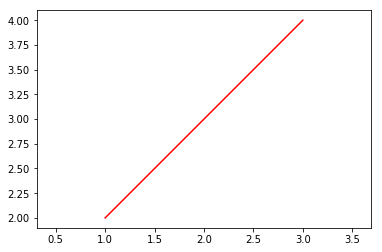

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=a
a.setTo(None)
b.plot()

(1, 2) (3, 4) red
 


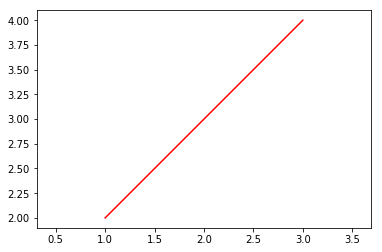

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=a
a=(Bundle(makeSeg(1,2,3,5,0)))
b.plot()

In [0]:
bl=BundleList(10)
flag1=makeFlag(1,2,3,4,1,0)
flag2=makeFlag(1,2,3,4,0,0)
bl.processFlag(flag2)
bl.processFlag(flag1)
bl.plot()
flag3=makeFlag(1,2,3,4,0,1)
bl.processFlag(flag3)
flag4=makeFlag(1,2,3,4,1,1)
bl.processFlag(flag4)
bl.plot()

cu=cl=1, one blue bundle in between


UnboundLocalError: local variable 'redHigh' referenced before assignment

In [0]:
s=AllSegments()
for i in range(0,10,2):
    s.addBlue(-i-1,i-2,0,0)
for i in range(11,1,-2):
    s.addBlue(-i-1,i-2,0,0)
b=Bundle(1)
s.sortFlags()
for i in range(5):
    b.insertB(s.blue[2*i])
b.plot()

In [0]:
for i in range(len(s.flags)):
    [node,x]=b.flagTest(s.flags[-i])
    if x!=0:
        s.flags[-i].prt()
        print(x)
        node.val.prt()
        print(' ')

In [0]:
tree = SplayTree()
tree.insert(33)
tree.insert(67)
tree.insert(44)
tree.insert(5)
tree.insert(112)
tree.insert(143)
tree.insert(165)
tree.insert(150)
l=tree.inorder()
print(l)

In [0]:
[treeA,treeB]=tree.split(143)
treeA.pprint()
print(treeA.min,treeA.max)
treeB.pprint()
print(treeB.min,treeB.max)

In [0]:
a=2
b=5
a=b
b=4
a

In [0]:
        else:
            if redLow.isIn(flag.seg):
                #if blueLow.abv is redHigh:
                    #record intersection of flag seg with blueLow
                redLow.delete(flag.seg)
                bdl=redLow
            elif redHigh.isIn(flag.seg):
                #if redLow.abv is blueHigh:
                    #record inters with flag seg and bluHigh
                redHigh.delete(flag.seg)
                bdl=redHigh
            elif blueLow.isIn(flag.seg):
                #if redLow.abv is blueHigh:
                    #record inters
                blueLow.delete(flag.seg)
                bdl=blueLow
            elif blueHigh.isIn(flag.seg):
                #if blueLow.abv is redHigh:
                    # record
                blueHigh.delete(flag.seg)
                bdl=blueHigh
            else:
                raise NameError("problem with process1")
            if bdl.root==None:
                b=bdl.bel
                a=bdl.abv
                
                b.abv=a
                a.bel=b
                
                if a.color==b.color:
                    self.__join(b,1)

In [0]:
#split first, then do the merge/swaps
#6 cases, state which case you are in

def makeSeg(px,py,qx,qy,col):
    return Segment(Point(px,py),Point(qx,qy),col)

def makeFlag(px,py,qx,qy,col,typ):
    seg=makeSeg(px,py,qx,qy,col)
    if typ==0:
        return Flag(seg,seg.p)
    return Flag(seg,seg.q)

#BundleList itself holds red bundles
class BundleList:
    def __init__(self,rang):
        redLow=Bundle(makeSeg(-rang,-rang,rang,-rang,0))
        
        blueLow=Bundle(makeSeg(-rang,-rang,rang,-rang,1))
        blueLow.bel=redLow
        redLow.abv=blueLow
        
        redHigh=Bundle(makeSeg(-rang,rang,rang,rang,0))
        redHigh.bel=blueLow
        blueLow.abv=redHigh
        
        blueHigh=Bundle(makeSeg(-rang,rang,rang,rang,1))
        blueHigh.bel=redHigh
        redHigh.abv=blueHigh
        
        
        self.lowest=redLow
        self.highest=blueHigh
    
    def plot(self):
        cur=self.lowest
        while cur.abv!=None:
            cur.plot()
            cur=cur.abv
        cur.plot()
        plt.show()
    
    
    #input: flag
    #output: red bundle directly below the flag or the bundle encompassing it
    def findFlag(self,flag):
        cur=self.lowest
        #invariant: cur is a red bundle that's below
        while cur.abv.abv!=None and flag.cmpSeg(cur.abv.abv.max)>0:
            cur=cur.abv.abv
        
        #check if the above red bundle contains the flag
        if cur.abv.abv!=None and flag.cmpSeg(cur.abv.abv.min)>=0:
            cur=cur.abv.abv
        return cur
    
    #input:bundle to swap, 
    #output: if d==1 swap up, d==0 swap down; joins nearby same colored bundles
    def __swap(self,bundle,d):
        #bottom, a, b, top; to bottom, b, a, top
        if d==1:
            a=bundle
            b=bundle.abv
        else:
            a=bundle.bel
            b=bundle
        assert a.color!=b.color
        bottom=a.bel
        top=b.abv
        
        bottom.abv=b
        b.bel=bottom

        b.abv=a
        a.bel=b

        a.abv=top
        top.bel=a
        if a.color==top.color:
            a=self.__join(a,1)
        if b.color==bottom.color:
            b=self.__join(b,0)
        
        if d==1:
            return a
        else:
            return b
            
    
    #input:bundle that is splitting, flag to split at
    #output: splits the bundle
    def __split(self,bundle,flag,d):
        #no trivial splits
        assert flag.cmpSeg(bundle.min)>=0 and flag.cmpSeg(bundle.max)<=0
        bottom=bundle.bel
        top=bundle.abv
        [b1,b2]=bundle.splitB(flag,d)
        if b1 is b2:
            return [b1,b2]
        
        bottom.abv=b1
        b1.bel=bottom
        
        b1.abv=b2
        b2.bel=b1
        
        b2.abv=top
        top.bel=b2
        return [b1,b2]
    
    #input:bundle, d the direction it is joining
    #output: d==1: join with Higher, else join with lower
    def __join(self,bundle,d):
        if d==1:
            a=bundle
            b=bundle.abv
        else:
            a=bundle.bel
            b=bundle
        assert a.color==b.color
        top=b.abv
        bot=a.bel
        a.joinB(b)
        
        a.abv=top
        top.bel=a
        
        bot.abv=a
        a.bel=bot
        assert a.color!=a.abv.color and top.color!=top.bel.color
        return a
    
    #input: bundle, flag
    #output: return 0 if flag is above bundle.abv.max, return 1 if not, return 2 if flag is inside bundle.abv
    def __checkHigher(self,bundle,flag):
        if bundle.abv==None:
            return 1
        
        above=bundle.abv 
        if flag.cmpSeg(above.max)>0:
            return 0
        elif flag.cmpSeg(above.min)>=0:
            return 2
        else:
            return 1
    def __checkLower(self,bundle,flag):
        if bundle.bel==None:
            return 1
        
        below=bundle.bel
        if flag.cmpSeg(below.min)<0:
            return 0
        elif flag.cmpSeg(below.max)<=0:
            return 2
        else:
            return 1
    
    #input: bundle
    #output: removes the bundle from the bundleList if the bundle is empty
    def __removeBundle(self,bundle):
        if bundle.root==None:
            bot=bundle.bel
            top=bundle.abv
            bot.abv=top
            top.bel=bot
            self.__join(bot,1)
            return True
        return False
    
    #decide the where to include equality segments by knowing whether it is swapping up or down
    def __process1(self,flag):
        bundle=self.findFlag(flag)
        #print("bundle it's in")
        #bundle.plot()
        if flag.cmpSeg(bundle.max)>0:
            redBs=[bundle,bundle.abv.abv]
        else:
            blueAbv=bundle.abv
            blueBel=bundle.bel
            tf=True
            if flag.cmpSeg(blueAbv.min)>=0:
                redBs=self.__split(bundle,flag,1)
                tf=False
            if flag.cmpSeg(blueBel.max)<=0:
                redBs=self.__split(bundle,flag,0)
                assert tf
        
        assert self.__checkHigher(redBs[1],flag)!=0 or self.__checkLower(redBs[0],flag)!=0
        
        while self.__checkHigher(redBs[1],flag)==0:
            redBs[1]=self.__swap(redBs[1],1)
            
        while self.__checkLower(redBs[0],flag)==0:
            redBs[0]=self.__swap(redBs[0],0)
            
        cu=self.__checkHigher(redBs[1],flag)
        cl=self.__checkLower(redBs[0],flag)
        assert cu!=0 and cl!=0
        
        if cu==2:
            print('cu=2')
            blueBs=self.__split(redBs[1].abv,flag,0)
            self.__swap(blueBs[0],0)
            assert blueBs[0].abv is redBs[1]
        elif cl==2:
            print('cl=2')
            blueBs=self.__split(redBs[0].bel,flag,1)
            self.__swap(blueBs[1],1)
            #ipdb.set_trace()
            assert blueBs[1].bel is redBs[0]
        elif redBs[0].abv.abv is redBs[1]:
            print('cu=cl=1, one blue bundle in between')
            blue=redBs[0].abv
            if flag.cmpSeg(blue.max)<=0 and flag.cmpSeg(blue.min)>=0:
                blueBs=self.__split(blue,flag,0)
            elif flag.cmpSeg(blue.max)>0:
                blueBs=[blue,blue.abv.abv]
            else:
                blueBs=[blue.bel.bel,blue]
        elif redBs[0].abv is redBs[1]:
            print('cu=cl=1, red bundles together')
            blueBs=[redBs[0].bel,redBs[1].abv]
        else:
            print('cu=cl=1')
            blueBs=[redBs[1].bel,redBs[1].abv]
            if flag.cmpSeg(blueBs[0].max)<0 or flag.cmpSeg(blueBs[1].bel)>=0:
                blueBs[0]=[redBs[0].bel,redBs[1].abv]
        assert redBs[0].color==0 and redBs[1].color==0 and blueBs[0].color==1 and blueBs[1].color==1
        
        return [redBs,blueBs]
    
    
    def processFlag(self,flag):
        [redBs,blueBs]=self.__process1(flag)
        #redBs[0].plot()
        #redBs[1].plot()
        #blueBs[0].plot()
        #blueBs[1].plot()
        #plt.show()
        fc=flag.seg.color
        if flag.type==0:
            if blueBs[0].abv is redBs[1]:
                #print('blueBs[0].abv is redBs[1]')
                if fc==0:
                    redBs[1].insertB(flag.seg)
                else:
                    blueBs[0].insertB(flag.seg)
            elif redBs[0].abv is blueBs[1]:
                #print('redBs[0].abv is blueBs[1]')
                if fc==0:
                    redBs[0].insertB(flag.seg)
                else:
                    blueBs[1].insertB(flag.seg)
            elif blueBs[0].abv is blueBs[1]:
                #print('blueBs[0].abv is blueBs[1]')
                if fc==0:
                    newR=Bundle(flag.seg)
                    blueBs[0].abv=newR
                    newR.bel=blueBs[0]
                    
                    newR.abv=blueBs[1]
                    blueBs[1].bel=newR
                else:
                    blue=self.__join(blueBs[0],1)
                    blue.insertB(flag.seg)
            elif redBs[0].abv is redBs[1]:
                #print('redBs[0].abv is redBs[1]')
                if fc==1:
                    newB=Bundle(flag.seg)
                    redBs[0].abv=newB
                    newB.bel=redBs[0]
                    
                    newB.abv=redBs[1]
                    redBs[1].bel=newB
                else:
                    red=self.__join(redBs[0],1)
                    red.insertB(flag.seg)
            else:
                raise NameError("problem with process1")
        else:
            if redBs[0].isIn(flag.seg):
                redBs[0].delete(flag.seg)
                self.__removeBundle(redBs[0])
            elif redBs[1].isIn(flag.seg):
                redBs[1].delete(flag.seg)
                self.__removeBundle(redBs[1])
            elif blueBs[0].isIn(flag.seg):
                blueBs[0].delete(flag.seg)
                self.__removeBundle(blueBs[0])
            elif blueBs[1].isIn(flag.seg):
                blueBs[1].delete(flag.seg)
                self.__removeBundle(blueBs[1])
            else:
                raise NameError("problem with process1")
        